# **Learning Face Hallucination in the Wild (2015)**

```
# This is formatted as code
@inproceedings{zhou2015learning,
  title={Learning face hallucination in the wild},
  author={Zhou, Erjin and Fan, Haoqiang and Cao, Zhimin and Jiang, Yuning and Yin, Qi},
  booktitle={Proceedings of the AAAI conference on artificial intelligence},
  volume={29},
  number={1},
  year={2015}
}
```





In [ ]:
data_path = "/content/drive/MyDrive/Research/Images"

In [ ]:
one_img = "/content/drive/MyDrive/Research/Images/000001.jpg"

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

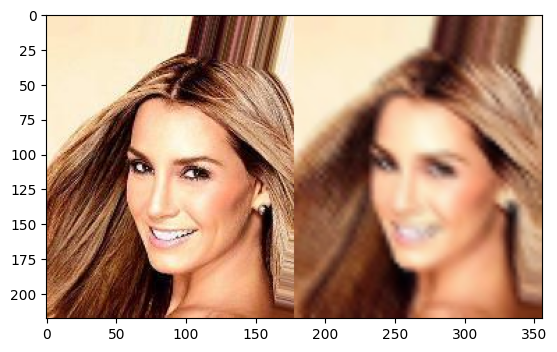

In [ ]:
def generate_lr_image_opencv(image_path, blur_type='gaussian', downscale_factor=3):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR by default

    # Apply blur
    if blur_type == 'gaussian':
        blurred = cv2.GaussianBlur(image, (15, 15), sigmaX=3, sigmaY=3)
    elif blur_type == 'motion':
        kernel = np.zeros((15, 15))
        cv2.line(kernel, (7, 7), (12, 12), 1, thickness=1)  # Diagonal motion
        kernel = kernel / kernel.sum()
        blurred = cv2.filter2D(image, -1, kernel)

    # Downsample
    h, w = image.shape[:2]
    lr_image = cv2.resize(blurred, (w//downscale_factor, h//downscale_factor),
                         interpolation=cv2.INTER_CUBIC)

    return lr_image, image

# Usage
lr, hr = generate_lr_image_opencv(one_img, blur_type='motion')
plt.imshow(np.hstack([hr, cv2.resize(lr, (hr.shape[1], hr.shape[0]))]))
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import random
from google.colab import drive
from tqdm import tqdm

# Mount Google Drive
#drive.mount('/content/drive')

# Configuration
input_folder = '/content/drive/MyDrive/Research/Images'  # Change to your folder
output_folder = '/content/drive/MyDrive/Research/LRImages'
os.makedirs(output_folder, exist_ok=True)

# Parameters
downscale_factor = random.randint(2, 5)  # Random downscale between 2-5 as in paper
kernel_size = 15

def generate_lr_image(hr_image):
    """Generate LR image with random blur type"""
    blur_type = random.choice(['gaussian', 'motion'])

    if blur_type == 'gaussian':
        sigma = random.uniform(0.5, 7.0)  # Random sigma between 0.5-7.0 as in paper
        blurred = cv2.GaussianBlur(hr_image, (kernel_size, kernel_size), sigmaX=sigma, sigmaY=sigma)
    else:
        length = random.randint(1, 11)  # Random length between 1-11 as in paper
        angle = random.uniform(-180, 180)  # Random angle between -180 to 180 degrees

        kernel = np.zeros((kernel_size, kernel_size))
        center = kernel_size // 2
        end_x = int(center + length * np.cos(np.radians(angle)))
        end_y = int(center + length * np.sin(np.radians(angle)))
        cv2.line(kernel, (center, center), (end_x, end_y), 1, thickness=1)
        kernel = kernel / kernel.sum()
        blurred = cv2.filter2D(hr_image, -1, kernel)

    # Downsample
    h, w = hr_image.shape[:2]
    lr_image = cv2.resize(blurred, (w//downscale_factor, h//downscale_factor),
                         interpolation=cv2.INTER_CUBIC)
    return lr_image, blur_type

# Process all images
image_files = sorted([f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
blur_counts = {'gaussian': 0, 'motion': 0}

for filename in tqdm(image_files, desc="Processing images"):
    img_path = os.path.join(input_folder, filename)
    hr_image = cv2.imread(img_path)
    hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

    lr_image, blur_type = generate_lr_image(hr_image)
    blur_counts[blur_type] += 1

    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, cv2.cvtColor(lr_image, cv2.COLOR_RGB2BGR))

# Print summary
print(f"\nProcessing complete! Results:")
print(f"Total images processed: {len(image_files)}")
print(f"Gaussian blur applied: {blur_counts['gaussian']} images")
print(f"Motion blur applied: {blur_counts['motion']} images")
print(f"Downscale factor: {downscale_factor}x")
print(f"LR images saved to: {output_folder}")

Processing images: 100%|██████████| 100/100 [00:03<00:00, 31.96it/s]


Processing complete! Results:
Total images processed: 100
Gaussian blur applied: 48 images
Motion blur applied: 52 images
Downscale factor: 3x
LR images saved to: /content/drive/MyDrive/Research/LRImages


In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

In [61]:
## 1. Dataset Preparation (Matches Paper Specifications)
class PaperFaceDataset(Dataset):
    def __init__(self, hr_dir, lr_dir):
        """
        Initialize dataset with HR and LR image pairs
        Args:
            hr_dir: Path to high-resolution images (100x100)
            lr_dir: Path to low-resolution images (variable size, will be resized to 48x48)
        """
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.image_files = [f for f in os.listdir(lr_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

        # Transform for HR images (100x100)
        self.hr_transform = transforms.Compose([
            transforms.Resize((100, 100)),  # Ensure HR is 100x100
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Scale to [-1, 1]
        ])

        # Transform for LR images (resize to 48x48 as in paper)
        self.lr_transform = transforms.Compose([
            transforms.Resize((48, 48)),  # Resize to network input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Scale to [-1, 1]
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        """Returns LR-HR image pair with proper preprocessing"""
        img_name = self.image_files[idx]
        lr_img = Image.open(os.path.join(self.lr_dir, img_name)).convert('RGB')
        hr_img = Image.open(os.path.join(self.hr_dir, img_name)).convert('RGB')

        return self.lr_transform(lr_img), self.hr_transform(hr_img)

In [62]:
hr_dir = "/content/drive/MyDrive/Research/Images"
lr_dir = "/content/drive/MyDrive/Research/LRImages"
# Create dataset
dataset = PaperFaceDataset(hr_dir=hr_dir, lr_dir=lr_dir)


In [63]:
# Create data loader (paper uses batch_size=200)
train_loader = DataLoader(dataset, batch_size=6, shuffle=True)  # Smaller batch for Colab
def printingdata(dloader):
  for batch in dloader:
    data,h = batch
    print(data.shape)
    break
printingdata(train_loader)

torch.Size([6, 3, 48, 48])


In [64]:
def ddata(dloader):
  for batch in dloader:
    data,h = batch
    return data, h
lr, hr = ddata(train_loader)

In [65]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc_rec1 = nn.Linear(128*4*4, 2000)
        self.fc_rec2 = nn.Linear(2000, 30000)
        self.fc_alpha1 = nn.Linear(128*4*4, 100)
        self.fc_alpha2 = nn.Linear(100, 1)

    def forward(self, x):
        x1 = x
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        x_flat = x.view(x.size(0), -1)
        rec = F.tanh(self.fc_rec1(x_flat))
        print(rec.shape)
        rec = F.tanh(self.fc_rec2(rec))
        print(rec.shape)
        rec = rec.view(-1, 3, 100, 100)
        print(rec.shape)
        alpha = F.tanh(self.fc_alpha1(x_flat))
        print(alpha.shape)
        alpha = torch.sigmoid(self.fc_alpha2(alpha))
        print(alpha.shape)
        upsampled = F.interpolate(x1, size=(100, 100), mode='bicubic', align_corners=False)
        print(upsampled.shape)
        output = alpha.view(-1, 1, 1, 1) * upsampled + (1 - alpha.view(-1, 1, 1, 1)) * rec
        print(output.shape)
        return output, rec, alpha
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

output, rec, alpha = model(lr.to(device))

torch.Size([6, 2000])
torch.Size([6, 30000])
torch.Size([6, 3, 100, 100])
torch.Size([6, 100])
torch.Size([6, 1])
torch.Size([6, 3, 100, 100])
torch.Size([6, 3, 100, 100])


In [66]:
alpha.shape

torch.Size([6, 1])

In [67]:
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from torchvision import transforms
from PIL import Image

def compute_psnr_ssim(generated, ground_truth):
    """
    Compute PSNR and SSIM between generated and ground truth images

    Args:
        generated: PIL Image or tensor (C,H,W) in range [0,1]
        ground_truth: PIL Image or tensor (C,H,W) in range [0,1]

    Returns:
        psnr, ssim: float values
    """
    # Convert to numpy arrays if needed
    if isinstance(generated, Image.Image):
        generated = transforms.ToTensor()(generated).numpy()
    if isinstance(ground_truth, Image.Image):
        ground_truth = transforms.ToTensor()(ground_truth).numpy()

    # If tensors, convert to numpy
    if torch.is_tensor(generated):
        generated = generated.detach().cpu().numpy()
    if torch.is_tensor(ground_truth):
        ground_truth = ground_truth.detach().cpu().numpy()

    # Ensure shape is (H,W,C)
    if generated.shape[0] == 3:  # (C,H,W) -> (H,W,C)
        generated = np.transpose(generated, (1, 2, 0))
    if ground_truth.shape[0] == 3:
        ground_truth = np.transpose(ground_truth, (1, 2, 0))

    # Convert to 8-bit for skimage
    generated_uint8 = (generated * 255).astype(np.uint8)
    gt_uint8 = (ground_truth * 255).astype(np.uint8)

    # Compute PSNR
    psnr = peak_signal_noise_ratio(gt_uint8, generated_uint8, data_range=255)

    # Compute SSIM (multichannel=True for color images)
    ssim = structural_similarity(gt_uint8, generated_uint8,
                               data_range=255,
                               multichannel=True,
                               channel_axis=2)

    return psnr, ssim



In [69]:
## 2. Exact Bi-Channel CNN Model (From Paper)
class BiChannelCNN(nn.Module):
    def __init__(self):
        """
        Exact implementation of the Bi-Channel CNN from the paper:
        - Feature extractor: 3 conv layers with tanh activation and max pooling
        - Image generator: Two parallel FC paths (reconstruction + alpha prediction)
        - Final output blends upsampled input and reconstruction using alpha
        """
        super().__init__()

        ### Feature Extractor (Section 3.3 in paper) ###
        # Conv1: 3->32 channels, 5x5 kernel, output 44x44 (48-5+1), pool to 22x22
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0)
        # Conv2: 32->64 channels, 3x3 kernel, output 20x20 (22-3+1), pool to 10x10
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        # Conv3: 64->128 channels, 3x3 kernel, output 8x8 (10-3+1), pool to 4x4
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(2, 2)  # All pooling layers are 2x2 with stride 2

        ### Image Generator (Section 3.4 in paper) ###
        # Path 1: Reconstructs HR image (matches paper's dimensions)
        self.fc_rec1 = nn.Linear(128*4*4, 2000)  # Paper: 2048->2000
        self.fc_rec2 = nn.Linear(2000, 30000)    # 100x100x3=30000 pixels

        # Path 2: Predicts fusion coefficient α (paper calls this "fusion coefficient")
        self.fc_alpha1 = nn.Linear(128*4*4, 100)  # Paper: 2048->100
        self.fc_alpha2 = nn.Linear(100, 1)        # Output single alpha value

    def forward(self, x):
        """
        Forward pass exactly as described in paper (Section 3.4)
        1. Feature extraction through conv layers
        2. Two parallel FC paths
        3. Blending with upsampled input
        """
        x1= x
        ### Feature Extraction ###
        # Conv1: 48x48x3 -> 44x44x32 -> pool to 22x22x32
        x = self.pool(F.tanh(self.conv1(x)))
        # Conv2: 22x22x32 -> 20x20x64 -> pool to 10x10x64
        x = self.pool(F.tanh(self.conv2(x)))
        # Conv3: 10x10x64 -> 8x8x128 -> pool to 4x4x128
        x = self.pool(F.tanh(self.conv3(x)))

        # Flatten features for FC layers (batch_size, 128*4*4)
        x_flat = x.view(x.size(0), -1)

        ### Path 1: HR Image Reconstruction ###
        rec = F.tanh(self.fc_rec1(x_flat))        # 2000-dim
        rec = F.tanh(self.fc_rec2(rec))           # 30000-dim
        rec = rec.view(-1, 3, 100, 100)           # Reshape to 100x100x3

        ### Path 2: Alpha Prediction ###
        alpha = F.tanh(self.fc_alpha1(x_flat))    # 100-dim
        #alpha = torch.sigmoid(self.fc_alpha2(alpha))  # [0,1] range
        alpha = (F.tanh(self.fc_alpha2(alpha)))/2 + (1/2)

        ### Bi-Channel Fusion (Eq. 10 in paper) ###
        # Upsample input to 100x100 using bicubic interpolation
        upsampled = F.interpolate(x1, size=(100, 100), mode='bicubic', align_corners=False)

        # Blend using alpha (proper broadcasting for dimensions)
        # alpha shape: (batch_size, 1, 1, 1) for proper broadcasting
        output = alpha.view(-1, 1, 1, 1) * upsampled + (1 - alpha.view(-1, 1, 1, 1)) * rec

        return output, rec, alpha  # Return output + intermediates for analysis



In [70]:
## 3. Training Setup (Matches Paper Specifications)
def setup_training(hr_dir, lr_dir):
    """Prepare everything for training exactly as in paper"""
    # Create dataset
    dataset = PaperFaceDataset(hr_dir=hr_dir, lr_dir=lr_dir)

    # Create data loader (paper uses batch_size=200)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # Smaller batch for Colab

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BiChannelCNN().to(device)

    # Loss and optimizer (paper uses MSE and SGD with lr=1e-5, momentum=0.9)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

    return model, train_loader, criterion, optimizer, device


In [71]:
## 4. Training Loop (Simplified but Matches Paper Approach)
def train_model(model, loader, criterion, optimizer, device, epochs=10):
    """Training loop matching paper's approach"""
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for lr_imgs, hr_imgs in loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            # Forward pass
            outputs, _, _ = model(lr_imgs)
            loss = criterion(outputs, hr_imgs)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(loader):.4f}")

        # Learning rate adjustment (paper divides by 10 when validation stops improving)
        if epoch % 1000 == 0 and epoch > 0:  # Just showing the logic
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 10


Epoch 1, Loss: 0.1033
Epoch 2, Loss: 0.1048
Epoch 3, Loss: 0.1063
Epoch 4, Loss: 0.1063
Epoch 5, Loss: 0.1025
Epoch 6, Loss: 0.1067
Epoch 7, Loss: 0.1026
Epoch 8, Loss: 0.1073
Epoch 9, Loss: 0.1093
Epoch 10, Loss: 0.1077


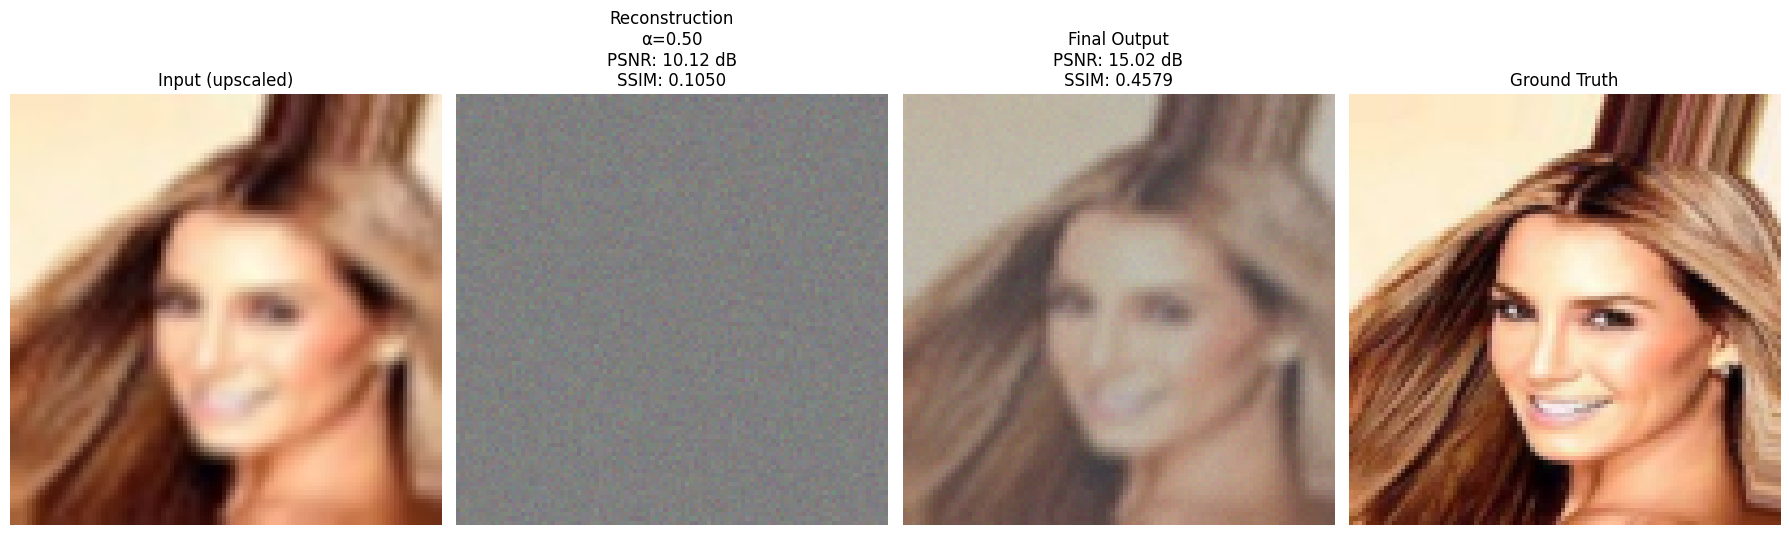

In [72]:
## 5. Example Usage with PSNR/SSIM Computation
if __name__ == "__main__":
    # Setup paths (change these to your folders)
    HR_FOLDER = "/content/drive/MyDrive/Research/Images"
    LR_FOLDER = "/content/drive/MyDrive/Research/LRImages"

    # Initialize training
    model, loader, criterion, optimizer, device = setup_training(HR_FOLDER, LR_FOLDER)

    # Train (paper uses 5000 epochs)
    train_model(model, loader, criterion, optimizer, device, epochs=10)

    # Test with a sample image and compute metrics
    def test_image(model, lr_path, hr_path):
        """Helper to test with one image and compute PSNR/SSIM"""
        # Load and transform images
        lr_img = Image.open(lr_path).convert('RGB')
        hr_img = Image.open(hr_path).convert('RGB')

        transform = transforms.Compose([
            transforms.Resize((48, 48)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        hr_transform = transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        lr_tensor = transform(lr_img).unsqueeze(0).to(device)
        hr_tensor = hr_transform(hr_img).unsqueeze(0).to(device)

        # Model prediction
        model.eval()
        with torch.no_grad():
            output, rec, alpha = model(lr_tensor)

        # Convert to PIL images
        def tensor_to_image(tensor):
            return transforms.ToPILImage()((tensor.squeeze().cpu() * 0.5 + 0.5).clamp(0, 1))

        input_img = tensor_to_image(lr_tensor).resize((100, 100))
        output_img = tensor_to_image(output)
        rec_img = tensor_to_image(rec)
        gt_img = tensor_to_image(hr_tensor)

        # Compute metrics
        def compute_metrics(pred, target):
            pred_np = (pred * 255).astype(np.uint8)
            target_np = (target * 255).astype(np.uint8)

            # PSNR
            psnr = peak_signal_noise_ratio(target_np, pred_np, data_range=255)

            # SSIM
            ssim = structural_similarity(target_np, pred_np,
                                       data_range=255,
                                       multichannel=True,
                                       channel_axis=2)
            return psnr, ssim

        # Convert to numpy arrays for metric computation
        output_np = np.array(output_img)
        rec_np = np.array(rec_img)
        gt_np = np.array(gt_img)

        # Compute metrics
        output_psnr, output_ssim = compute_metrics(output_np, gt_np)
        rec_psnr, rec_ssim = compute_metrics(rec_np, gt_np)

        # Display results
        import matplotlib.pyplot as plt
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 4, 1)
        plt.imshow(input_img)
        plt.title("Input (upscaled)")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(rec_img)
        plt.title(f"Reconstruction\nα={alpha.item():.2f}\nPSNR: {rec_psnr:.2f} dB\nSSIM: {rec_ssim:.4f}")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(output_img)
        plt.title(f"Final Output\nPSNR: {output_psnr:.2f} dB\nSSIM: {output_ssim:.4f}")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(gt_img)
        plt.title("Ground Truth")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Test with first image pair
    lr_path = os.path.join(LR_FOLDER, os.listdir(LR_FOLDER)[0])
    hr_path = os.path.join(HR_FOLDER, os.listdir(LR_FOLDER)[0])  # Assuming same filenames
    test_image(model, lr_path, hr_path)